In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as px
import seaborn as sns
import seaborn as sb
%matplotlib inline
import time
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [205]:
# Load Data
df = pd.read_csv('seattle_weather_1948-2017.csv')

In [206]:
df.shape

(25551, 5)

In [207]:
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [208]:
df.describe()

,PRCP,TMAX,TMIN
count,25548.000000,25551.000000,25551.000000
mean,0.106222,59.544206,44.514226
std,0.239031,12.772984,8.892836
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


In [209]:
df.dtypes

DATE     object
PRCP    float64
TMAX      int64
TMIN      int64
RAIN     object
dtype: object

In [210]:
np.mean(df['RAIN']==True)*100

42.659778482251184

In [211]:
df['PRCP']


0        0.47
1        0.59
2        0.42
3        0.31
4        0.17
         ... 
25546    0.00
25547    0.00
25548    0.00
25549    0.00
25550    0.00
Name: PRCP, Length: 25551, dtype: float64

### Build a heuristic model to predict if it will rain tomorrow.

## EDA

<AxesSubplot:ylabel='Frequency'>

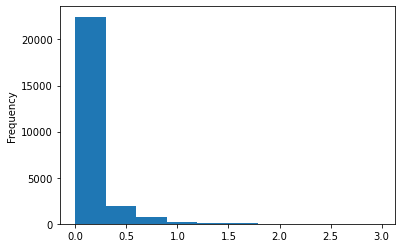

In [212]:
df['PRCP'].loc[df['PRCP' ]<3].plot.hist()


In [213]:
#Cleaninng Data

In [214]:
df.isnull().sum()


DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [215]:
df= df.dropna()
df

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25546,2017-12-10,0.00,49,34,False
25547,2017-12-11,0.00,49,29,False
25548,2017-12-12,0.00,46,32,False
25549,2017-12-13,0.00,48,34,False


C:\Users\iand9\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


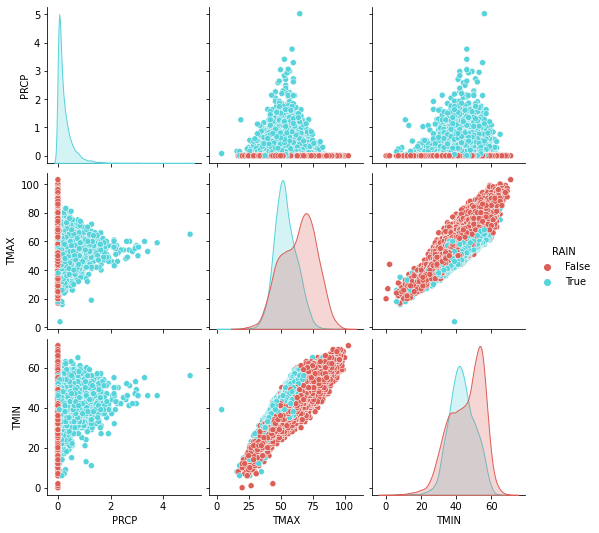

In [216]:
#Improve
sb.pairplot(data=df, hue="RAIN", palette='hls')

<AxesSubplot:>

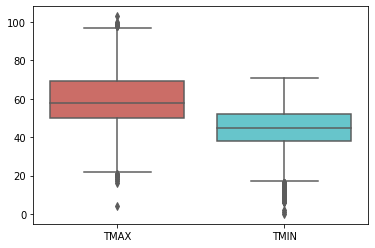

In [217]:
sb.boxplot(data=df,order=["TMAX", "TMIN"],palette='hls')


<AxesSubplot:>

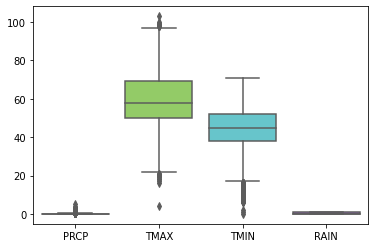

In [218]:
sb.boxplot(data=df,palette='hls')


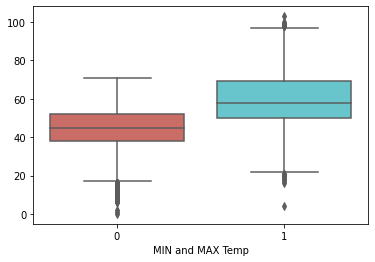

In [219]:
sns.boxplot(data=[df.TMIN , df.TMAX],palette='hls');
plt.xlabel('MIN and MAX Temp');

In [220]:
# Baseline Model Prediction

# What would be our accuracy if we predicted the majority class

df["RAIN"].value_counts(normalize=True)

False    0.573352
True     0.426648
Name: RAIN, dtype: float64

### How could we further improve our model?


## build the model manually

In [221]:


def heuristic(df):
    

    preds = []
    for x in range(len(df)):
        if x <2:
            preds.append(False)
        else:
      
            if (df.iloc[x-1]["RAIN"] == True) | (df.iloc[x-2]["RAIN"] == True):
              preds.append(True)
                
            elif (df.iloc[x-1]["TMAX"] >= 15) & (df.iloc[x-2]["TMAX"] <= 20):
                preds.append(True)

            elif (df.iloc[x-1]["TMIN"] >= 15) & (df.iloc[x-2]["TMIN"] <= 10):
                preds.append(True)
            else:
                preds.append(False)
    return preds

In [222]:
df["preds"]=heuristic(df)

In [223]:
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN,preds
0,1948-01-01,0.47,51,42,True,False
1,1948-01-02,0.59,45,36,True,False
2,1948-01-03,0.42,45,35,True,True
3,1948-01-04,0.31,45,34,True,True
4,1948-01-05,0.17,45,32,True,True


In [224]:
# Determine Accuracy

# Create function to to find values

def calc_confuse(df):
    
    "Calculate all possible results of a confusion matrix"
    
    # Initialzing the arrays to zero 
    # These arrays will be used to save the values
    FP = np.zeros(len(df))
    TP = np.zeros(len(df))
    FN = np.zeros(len(df))
    TN = np.zeros(len(df))
    
    for x in range(len(df)):
        
        # positive --> weather is raining 
        # negative --> weather is not raining 
        
        # True Positive
        if (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == True):
            TP[x] = 1
        # True Negative
        elif (df["RAIN"].iloc[x] == False) & (df["preds"].iloc[x] == False):
            TN[x] = 1
        # False Negative --> wrong prediction , prediction = not happening
        elif (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == False):
            FN[x] = 1
        # False Positive --> wrong prediction , prediction = happening
        else:
            FP[x] = 1
    
    return FP, TP, FN, TN

In [225]:
# Create a copy of the dataframe

df_temp = df.copy()

df_temp["preds"] = heuristic(df_temp) # Create a column of predictions

confuse_ls = [w,x,y,z] = calc_confuse(df_temp) # Calculate confusion matrix stats
col_names = ["FP", "TP", "FN", "TN"] # Create column name ls

# Create new columns
for x in range(len(confuse_ls)):
    df_temp[col_names[x]] = confuse_ls[x]

# Look at 10 random rows to determine the accuracy
df_temp.sample(10)

,DATE,PRCP,TMAX,TMIN,RAIN,preds,FP,TP,FN,TN
2836,1955-10-07,0.67,51,45,True,False,0.0,0.0,1.0,0.0
18673,1999-02-15,0.03,50,33,True,True,0.0,1.0,0.0,0.0
1407,1951-11-08,0.00,53,42,False,True,1.0,0.0,0.0,0.0
23128,2011-04-28,0.04,51,39,True,True,0.0,1.0,0.0,0.0
10938,1977-12-12,0.48,49,45,True,True,0.0,1.0,0.0,0.0
24361,2014-09-12,0.00,76,55,False,False,0.0,0.0,0.0,1.0
9622,1974-05-06,0.01,69,54,True,True,0.0,1.0,0.0,0.0
24405,2014-10-26,0.06,55,46,True,True,0.0,1.0,0.0,0.0
10852,1977-09-17,0.00,65,50,False,True,1.0,0.0,0.0,0.0
9173,1973-02-11,0.00,48,40,False,True,1.0,0.0,0.0,0.0


In [226]:
# Calculate Accuracy

(sum(df_temp["TP"]) + sum(df_temp["TN"])) / len(df_temp)



0.6707765774228902

In [227]:
# Calculate Precision 

sum(df_temp["TP"])/ (sum(df_temp["TP"]) + sum(df_temp["FN"]))
    

0.7837614678899083

In [228]:
# Calculate Recall

sum(df_temp["TP"])/ (sum(df_temp["TP"]) + sum(df_temp["FP"]))
    

0.5852572446393094

### -----------------------------------------------------------------------------------------------

### Split into Train and test

In [229]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

x = df[['PRCP', 'TMAX', 'TMIN']] 
y = df.RAIN.astype(np.int32) 

X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.70)

### Apply ML Model

In [230]:
logpReg = LogisticRegression()


In [231]:
logpReg.fit(X=X_train, y=y_train)


LogisticRegression()

In [232]:

logpReg.predict(X_test)


array([0, 0, 0, ..., 0, 1, 0])

In [233]:
preds = logpReg.predict(X_test)


In [234]:
#improve
# Report highest accuracy with %
accuracy=logpReg.score(X_test,y_test)
print(accuracy*100)

92.8897586431833
